# Depth Segmentation

In this notebook I attempt to train a unet model to predict depth

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import h5py
from fastai.vision import *

## Loading the Data

In [3]:
url = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
dst = Config.data_path()/'nyu_depth_v2_labeled.mat'
download_url(url, dst)
f = h5py.File(dst,'r')

In [4]:
depthData = torch.from_numpy(np.array(f['depths'])).permute(0,2,1)
depthData = depthData[:,None,:,:]

In [5]:
imageData = torch.from_numpy(np.array(f['images'])).permute(0,1,3,2)
imageData = imageData.float()/25
imageData.shape

torch.Size([1449, 3, 480, 640])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2e92a9cc50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2e91206a90>)

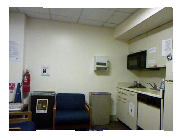

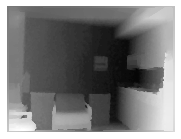

In [6]:
show_image(imageData[0]), show_image(depthData[0])

In [7]:
del f

## Setting up learner

In [8]:
class ImageListD(ImageList):
    def open(self, i):
        return Image(depthData[i])

class ImageListM(ImageList):
    def open(self, i):
        return Image(imageData[i])

In [9]:
items = list(range(len(imageData)))
depths = ImageListD(items)
images = ImageListM(items)
# tfms = get_transforms(max_lighting=None)
# for t in tfms[0]:
#     t.use_on_y = False
# for t in tfms[1]:
#     t.use_on_y = False

In [10]:
train = LabelList(images[0:1304], depths[0:1304])
valid = LabelList(images[1305:], depths[1305:])
del depths
del images
data = LabelLists('.', train, valid)

In [11]:
data = data.databunch().normalize(imagenet_stats, do_y=False)
data.one_batch()

(tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],
 
 
         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1

In [12]:
def smse(i, t):
    return torch.sqrt(mse(i,t))

def cbs(learn):
    return [SaveModelCallback(learn, every='improvement', monitor='smse', name='best', mode='min')]

def get_pred(learn, pic=None):
    if pic is None: 
        i = random.randint(0, len(learn.data.valid_ds))
        learn.data.valid_ds.y[i].show()
        pic = learn.data.valid_ds.x[i]
    
    pic.show()
    learn.predict(pic)[0].show()

## Training
After experimenting with hyper parameters, I decided to go big. The results I get from the resnet34 architecture are ok but the best results are achieved on the resnet50

In [13]:
learn = unet_learner(data, models.resnet34, loss_func=mse, metrics=smse, callback_fns=ShowGraph)
learn.unfreeze()

In [14]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


OSError: [Errno 12] Cannot allocate memory

In [ ]:
learn.fit_one_cycle(40, slice(1e-5, 1e-4), callbacks=cbs(learn))

In [ ]:
try:
    learn.destroy()
except NameError:
    pass

data.batch_size = 7
learn = unet_learner(data, models.resnet50, loss_func=mse)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(40, slice(1e-5, 1e-4), callbacks=cbs(learn))

# Conclusion


In [ ]:
learn = unet_learner(data, models.resnet50, loss_func=mse)
p = os.path.abspath('./models/model_best')
learn.load(p)
learn.export()
# get_pred(learn, open_image('/home/h/Desktop/selfie.jpg'))

Resultse aren't too bad and we can clearly make out shapes of objects very close by.

Further work on this project would be to split up the data as specified for the NY2 to compare the results.

- Experiementing with transformations (Some might be making the model worse)
- vgg based encoder
- Larger resnet encoder
- Add focal length of camera from dataset into the network as suggested by some papers